# Import Libraries

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import pacf
from matplotlib import pyplot as plt
from typing import List
from glob import glob
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Data Loading

In [25]:
datasets_paths = glob("../data/*.csv")
datasets: List[pd.DataFrame] = [pd.read_csv(path) for path in datasets_paths]

# Data Preparation

- Treat the records with `anomaly = True` from the dataset, and then impute them.
- Remove the `anomaly` column from the dataset.

In [26]:
for i, dataset in enumerate(datasets):
    if "anomaly" in dataset.columns:
        # Replace anomalies with 'NaN'
        dataset.loc[dataset.anomaly == 1, "value"] = np.nan

        # Remove the 'anomaly' column
        dataset = dataset.drop(columns=["anomaly"])

        # Update the dataset
        datasets[i] = dataset

- Convert the timestamp column to the `datetime` datatype
- Set the timestamp column as the index of the dataframe

In [27]:
for i, dataset in enumerate(datasets):
    # Convert the 'timestamp' column to datetime
    dataset["timestamp"] = pd.to_datetime(dataset["timestamp"])

    # Set the 'timestamp' column as the index
    dataset = dataset.set_index("timestamp")

    # Update the dataset
    datasets[i] = dataset

- Remove Outliers

In [28]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def __zscore(self, X):
        X = np.nan_to_num(X, copy=True, nan=0)  # Convert the NaN values to 0
        return (X - np.mean(X)) / np.std(X)

    def transform(self, X: pd.DataFrame, y=None):
        """
        Calculate the z-score for each column in the DataFrame and remove the rows with z-score > threshold
        """

        X_copy = X.copy().to_numpy()
        for i in range(X_copy.shape[1]):
            column = X_copy[:, i]
            z_scores = self.__zscore(column)
            outliers = np.abs(z_scores) > self.threshold
            X_copy[outliers] = np.nan

        return X_copy

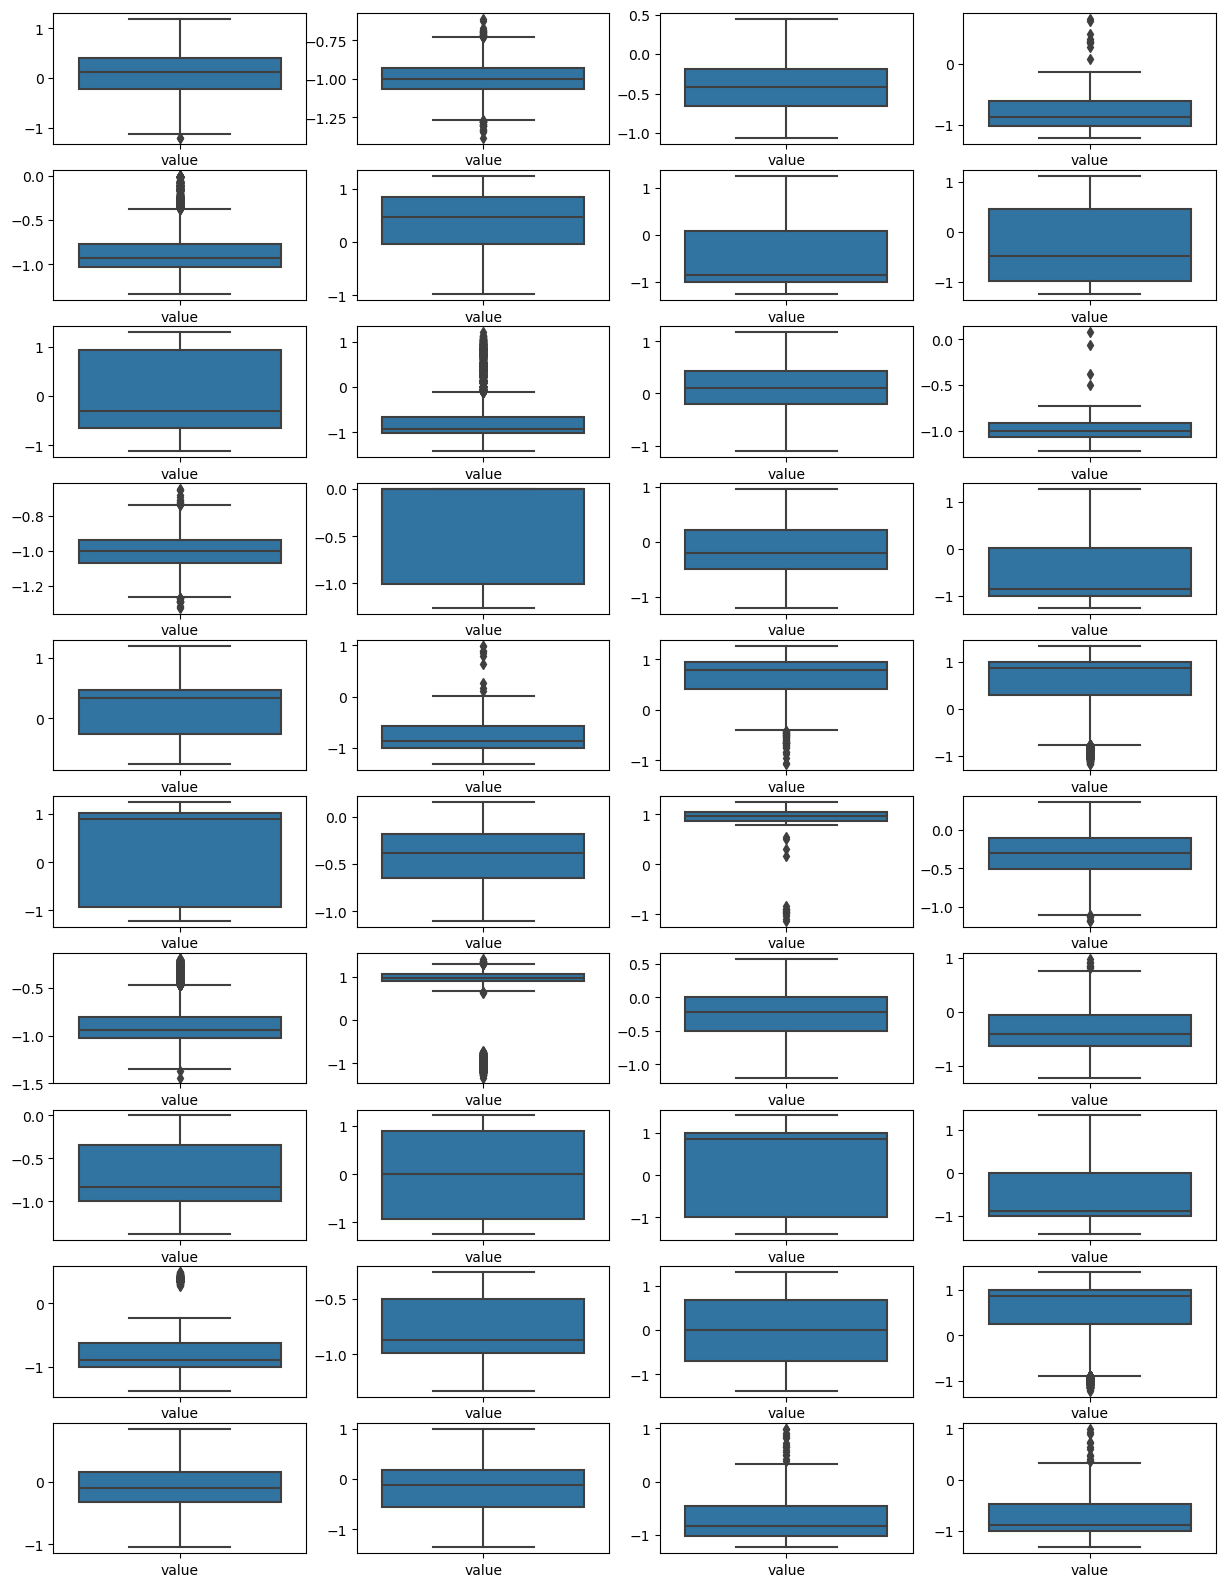

In [29]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

In [30]:
# datasets values with no outliers
datasets_values = [
    OutlierTransformer(threshold=2).fit_transform(dataset) for dataset in datasets
]

In [31]:
# Update the datasets with the new values (without the outliers)
datasets = [
    pd.DataFrame(data=values, columns=dataset.columns, index=dataset.index)
    for values, dataset in zip(datasets_values, datasets)
]

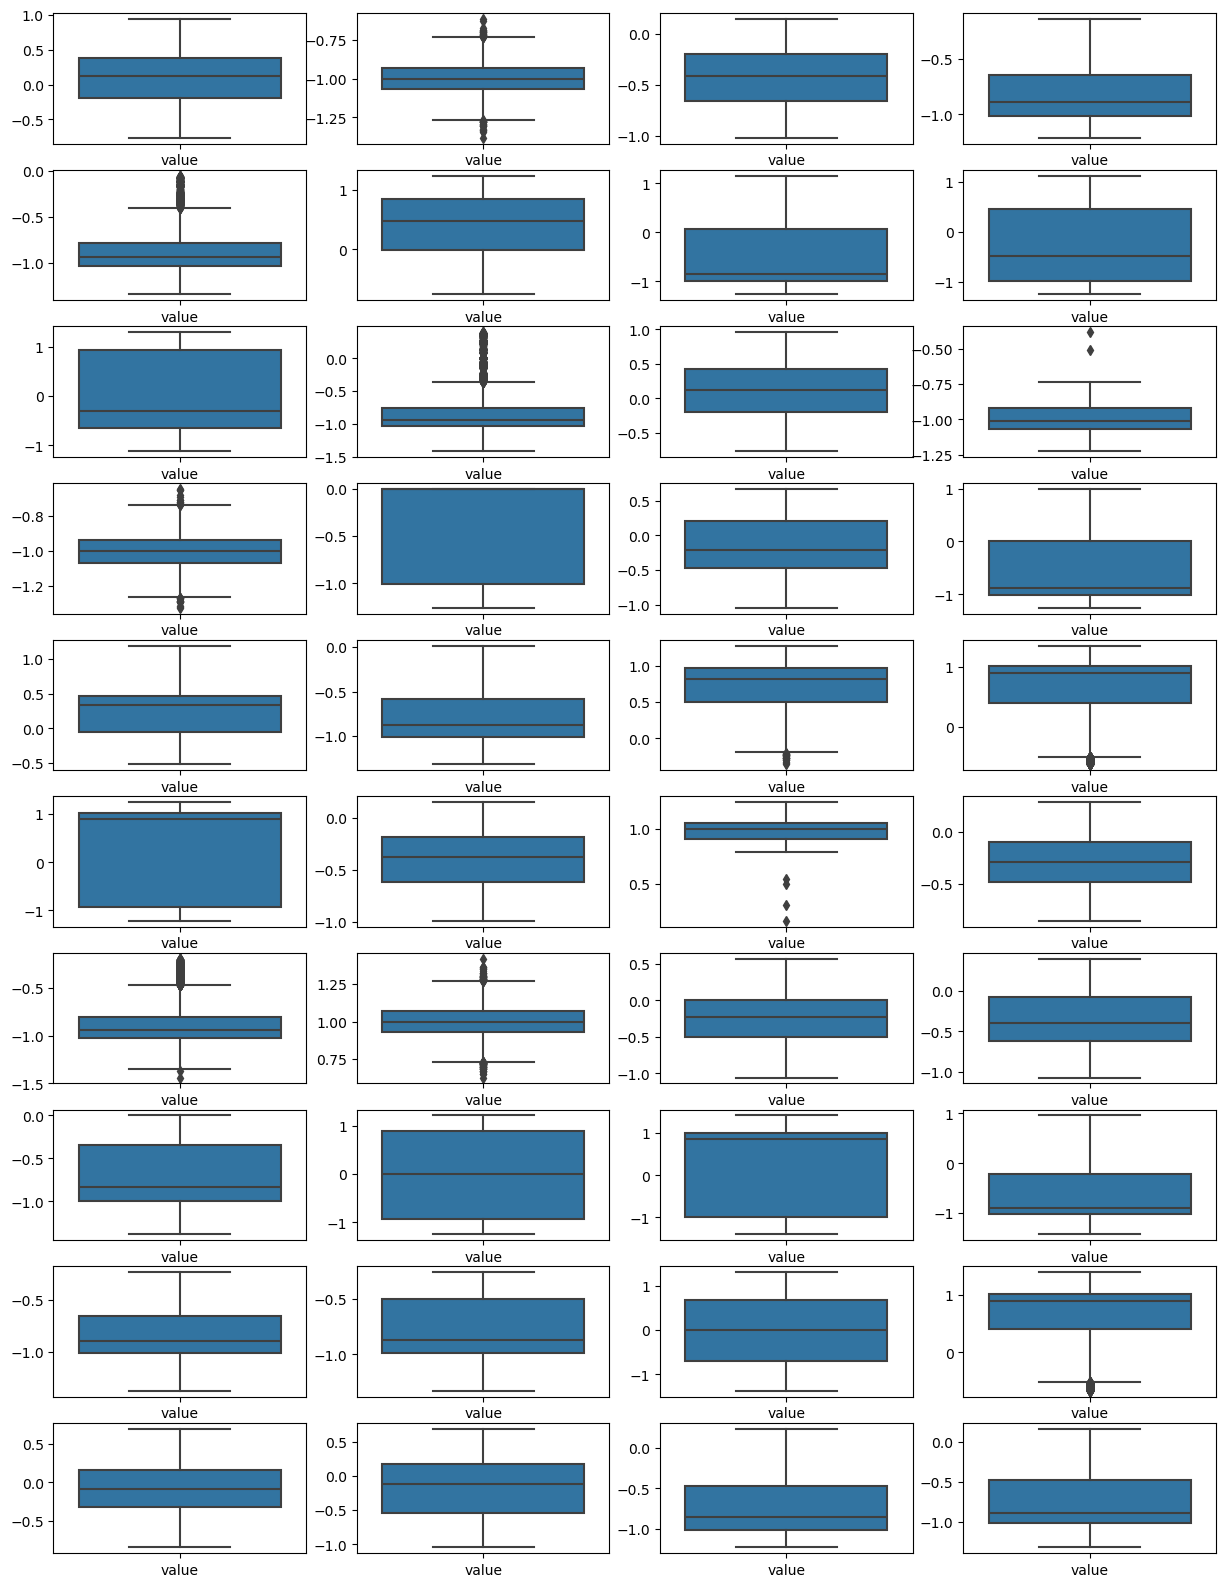

In [32]:
fig, axes = plt.subplots(10, 4, figsize=(15, 20))
for ax, dataset in zip(axes.ravel(), datasets):
    sns.boxplot(dataset, ax=ax)

plt.show()

# Data Preprocessing Pipeline

## Data Cleaning

- Impute missing values using `Interpolation`

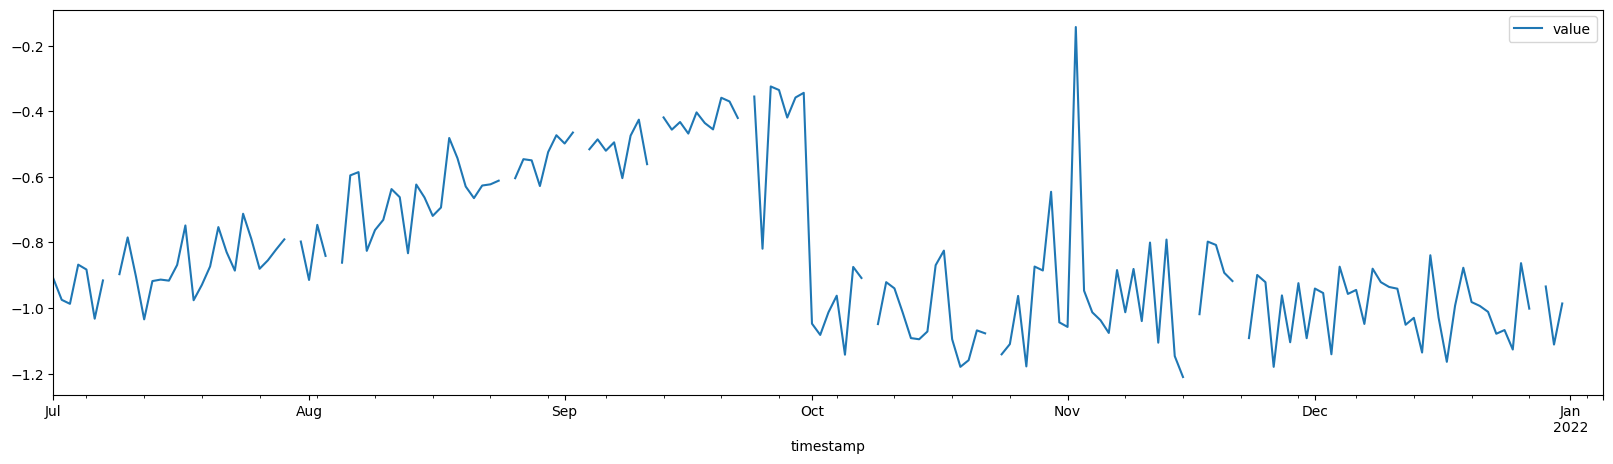

In [33]:
sample_dataset = datasets[3].copy()

sample_dataset.plot(figsize=(20, 5))
plt.show()

In [34]:
class InterpolationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method="linear", order=None):
        self.method = method
        self.order = order

    def fit(self, X, y=None):
        return self

    def transform(self, X: np.ndarray, y=None):
        X_copy = X.copy()
        X_copy_df = pd.DataFrame(data=X_copy)
        X_copy_df.interpolate(method=self.method, order=self.order, inplace=True)

        return X_copy_df.to_numpy()

In [35]:
interpolation_transformer = InterpolationTransformer(method="quadratic")
sample_dataset_inter_values = interpolation_transformer.fit_transform(sample_dataset)

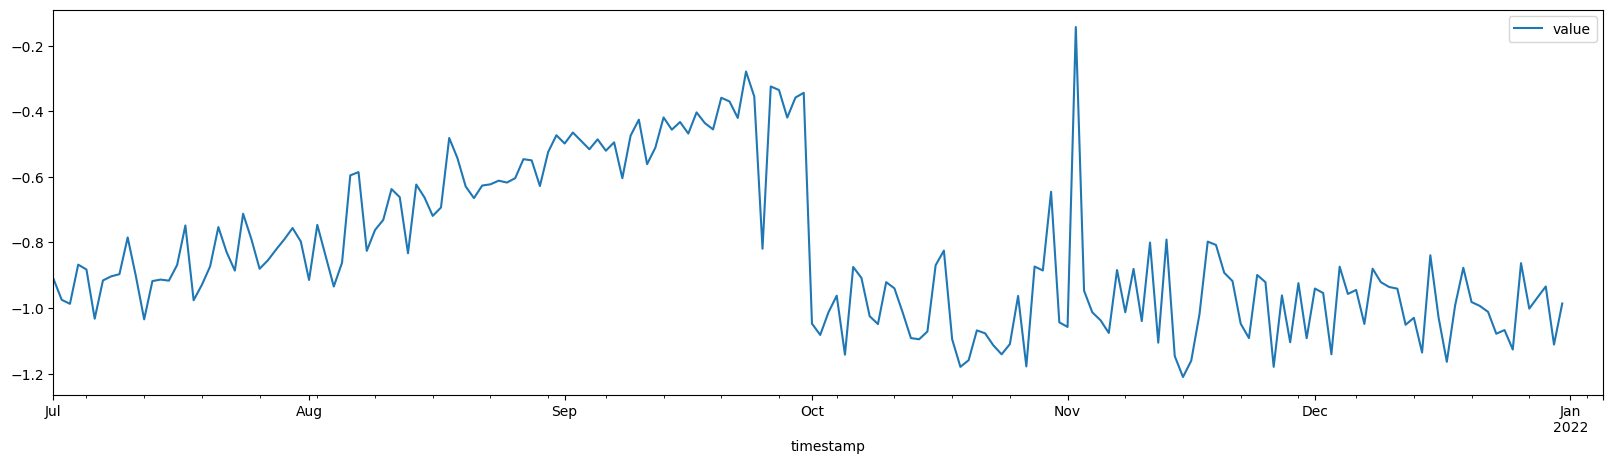

In [36]:
pd.DataFrame(
    data=sample_dataset_inter_values,
    columns=datasets[3].columns,
    index=datasets[3].index,
).plot(figsize=(20, 5))
plt.show()

## Feature Engineering

### Seasonality

Adding Seasonality features to the dataset based on its frequencies.

In [37]:
class SeasonalityFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, top=5):
        self.top = top
        self.top_freq: None

    def fit(self, X: np.ndarray, y=None):
        if any(np.isnan(X)):
            raise ValueError("The dataset contains NaN values")

        if X.shape[1] != 1:
            raise ValueError("The dataset should contain only one column")

        X_copy = X.copy()[:, 0]

        fft_result = np.fft.fft(X_copy)
        # Calculate only positive power spectral density
        psd = (np.abs(fft_result) ** 2)[: len(X_copy) // 2]
        freq = np.fft.fftfreq(len(X_copy), 1)[: len(X_copy) // 2]

        # Pick the top frequencies
        top_freq_indices = np.argsort(psd, axis=0)[::-1][1 : self.top + 1]
        self.top_freq = freq[top_freq_indices]

        return self

    def transform(self, X: np.ndarray, y=None):
        if any(np.isnan(X)):
            raise ValueError("The dataset contains NaN values")

        if X.shape[1] != 1:
            raise ValueError("The dataset should contain only one column")

        X_copy = X.copy()
        # Calculate the seasonality features
        seasonality_features = np.zeros((X_copy.shape[0], self.top * 2))
        for i, freq in enumerate(self.top_freq):
            seasonality_features[:, i] = np.sin(2 * np.pi * freq * X_copy[:, 0])
            seasonality_features[:, i + self.top] = np.cos(
                2 * np.pi * freq * X_copy[:, 0]
            )

        # Add the seasonality features to the dataset
        return np.concatenate((seasonality_features, X_copy), axis=1)

In [38]:
sample_dataset = datasets[5].copy()

In [39]:
# Impute the NaN values from the dataset (interpolation) before Seasonality Features
interpolation_transformer = InterpolationTransformer(method="quadratic")
sample_dataset_inter_values = interpolation_transformer.fit_transform(sample_dataset)

sample_dataset_inter = pd.DataFrame(
    data=sample_dataset_inter_values,
    columns=sample_dataset.columns,
    index=sample_dataset.index,
)

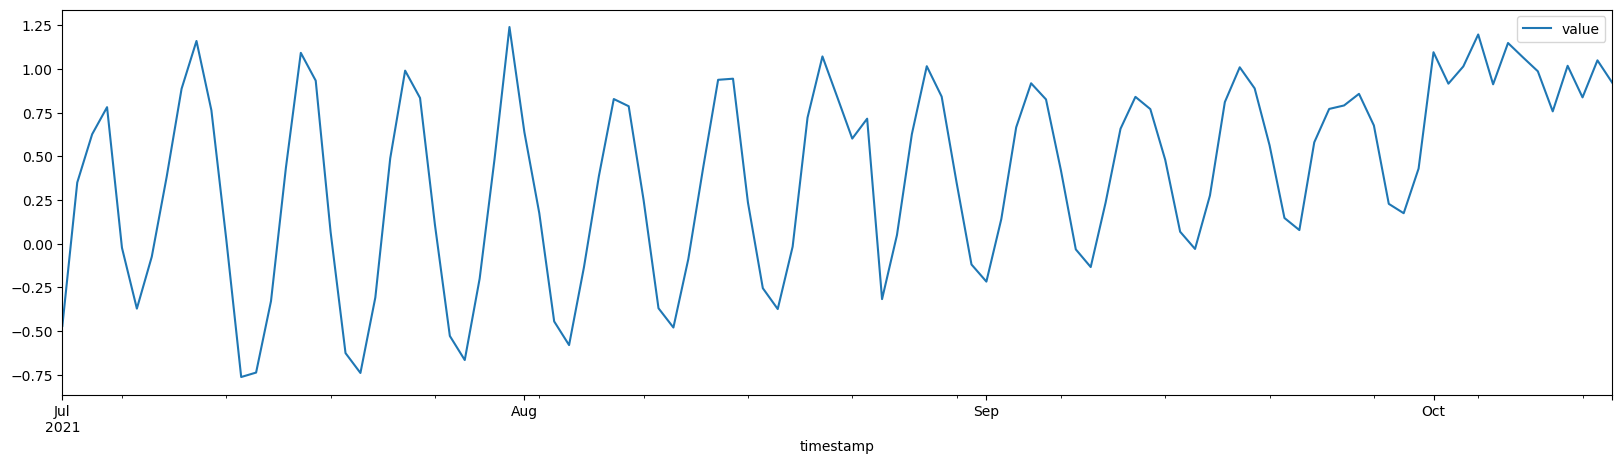

In [40]:
sample_dataset_inter.plot(figsize=(20, 5))
plt.show()

In [41]:
seasonality_transformer = SeasonalityFeaturesTransformer(top=1)
seasonality_transformer.fit(sample_dataset_inter_values)

SeasonalityFeaturesTransformer(top=1)

In [42]:
sample_dataset_seasonality_values = seasonality_transformer.transform(
    sample_dataset_inter_values
)

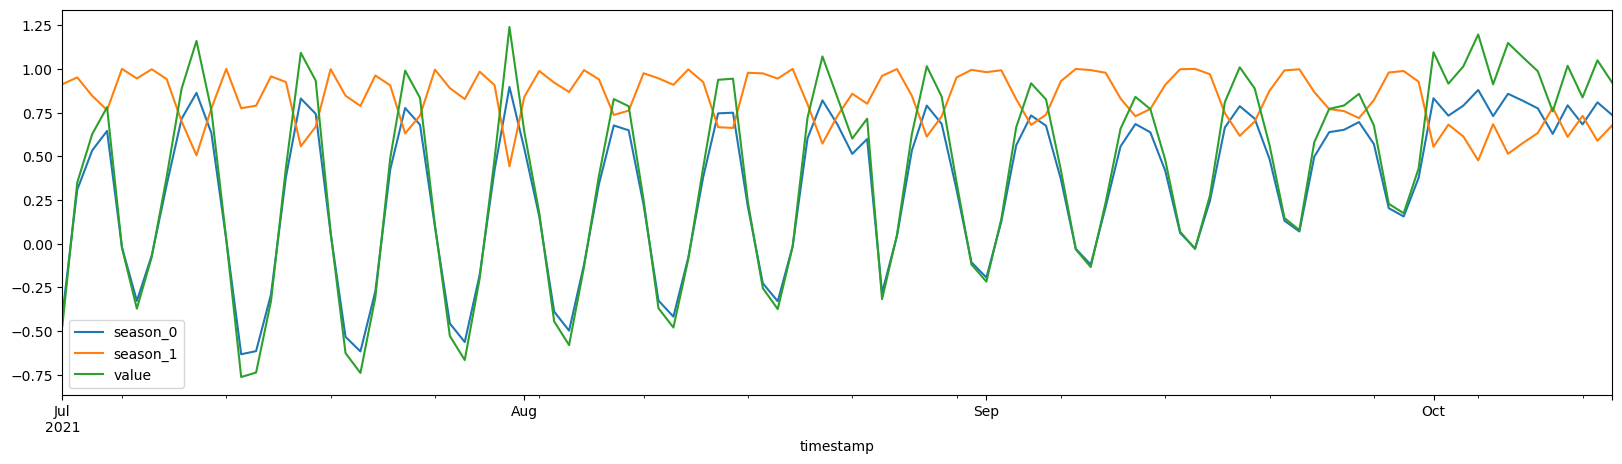

In [43]:
sample_dataset_seasonality = pd.DataFrame(
    data=sample_dataset_seasonality_values,
    columns=[f"season_{i}" for i in range(1 * 2)] + [*sample_dataset.columns],
    index=sample_dataset_inter.index,
)

sample_dataset_seasonality.plot(figsize=(20, 5))
plt.show()

### Trend

In [44]:
# Create Trend Transformer class
class TrendTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=10, degree=3):
        self.window_size = window_size
        self.degree = degree
        self.lr = LinearRegression()
        self.poly = PolynomialFeatures(degree=self.degree)

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        X_copy = X.copy()
        y_copy = y.copy()

        expanding_mean = (
            pd.Series(y_copy).expanding(self.window_size).mean().bfill().to_numpy()
        )

        features = self.poly.fit_transform(
            np.concatenate((X_copy, y_copy.reshape(-1, 1)), axis=1)
        )

        self.lr.fit(features, expanding_mean.reshape(-1, 1))

        return self

    def transform(self, X: np.ndarray, y=None):
        X_copy = X.copy()
        features = self.poly.fit_transform(X_copy)
        trend = self.lr.predict(features)

        return np.concatenate((X_copy, trend), axis=1)

In [45]:
trend_transformer = TrendTransformer(window_size=10, degree=3)

trend_transformer.fit(
    X=sample_dataset_seasonality_values[:, :-1],
    y=sample_dataset_seasonality_values[:, -1],
)

TrendTransformer()

In [46]:
sample_dataset_trend_values = trend_transformer.transform(
    sample_dataset_seasonality_values
)

<Axes: xlabel='timestamp'>

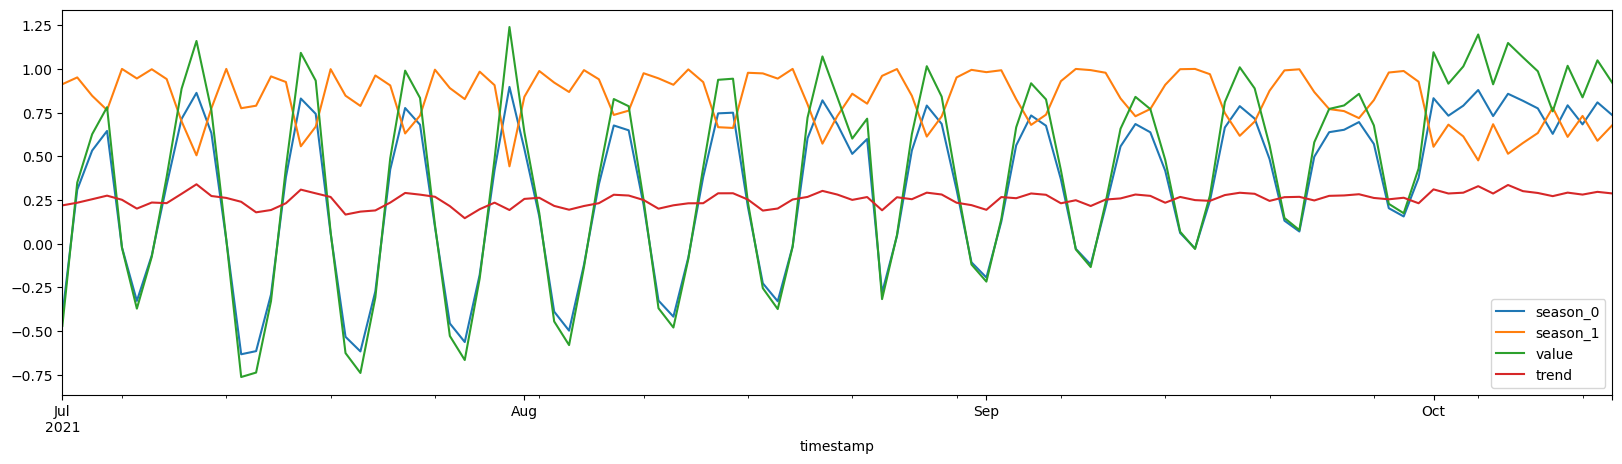

In [47]:
sample_dataset_trend = pd.DataFrame(
    data=sample_dataset_trend_values,
    columns=[*sample_dataset_seasonality.columns] + ["trend"],
    index=sample_dataset_inter.index,
)

sample_dataset_trend.plot(figsize=(20, 5))

### Lagged Features

Choosing the lagged features that are highly correlated with the target variable. 

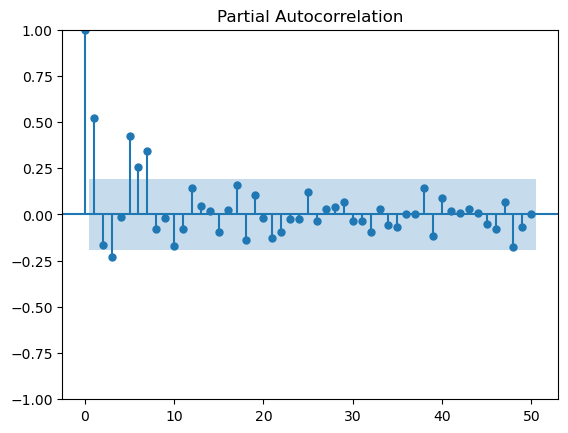

In [60]:
plot_pacf(sample_dataset_trend_values[:, -1], lags=50)
plt.show()

In [85]:
class AutocorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_lags=50):
        self.significant_lags = None
        self.max_lags = max_lags

    def fit(self, X, y=None):
        X_copy = X.copy()

        pacf_values = pacf(
            X_copy,
            nlags=X_copy.shape[0] // 2 - 1,
        )

        significant_lags = [
            i
            for i, value in enumerate(pacf_values)
            if abs(value) > 2 / len(X_copy) ** 0.5
        ]
        self.significant_lags = significant_lags[: self.max_lags]
        return self

    def transform(self, X: np.ndarray, y=None):
        X_copy = X.copy()

        # Excluding the first lag (autocorrelation = 1) and Lag 0 (constant)
        correlation_features = np.zeros(
            (X_copy.shape[0], len(self.significant_lags) - 1)
        )
        for i, lag in enumerate(self.significant_lags[1:], start=1):
            correlation_features[:, i] = np.roll(X_copy, lag)

        return np.concatenate((correlation_features, X_copy.reshape(-1, 1)), axis=1)

In [82]:
autocorrelation_transformer = AutocorrelationTransformer(max_lags=50)
autocorrelation_transformer.fit(sample_dataset_trend_values[:, -1])

AutocorrelationTransformer()

In [83]:
sample_dataset_lagged_values = autocorrelation_transformer.transform(
    sample_dataset_trend_values[:, -1]
)

sample_dataset_lagged = pd.DataFrame(
    data=sample_dataset_lagged_values,
    columns=[f"lag_{i}" for i in range(sample_dataset_lagged_values.shape[1] - 1)]
    + ["value"],
    index=sample_dataset_inter.index,
)

<Axes: xlabel='timestamp'>

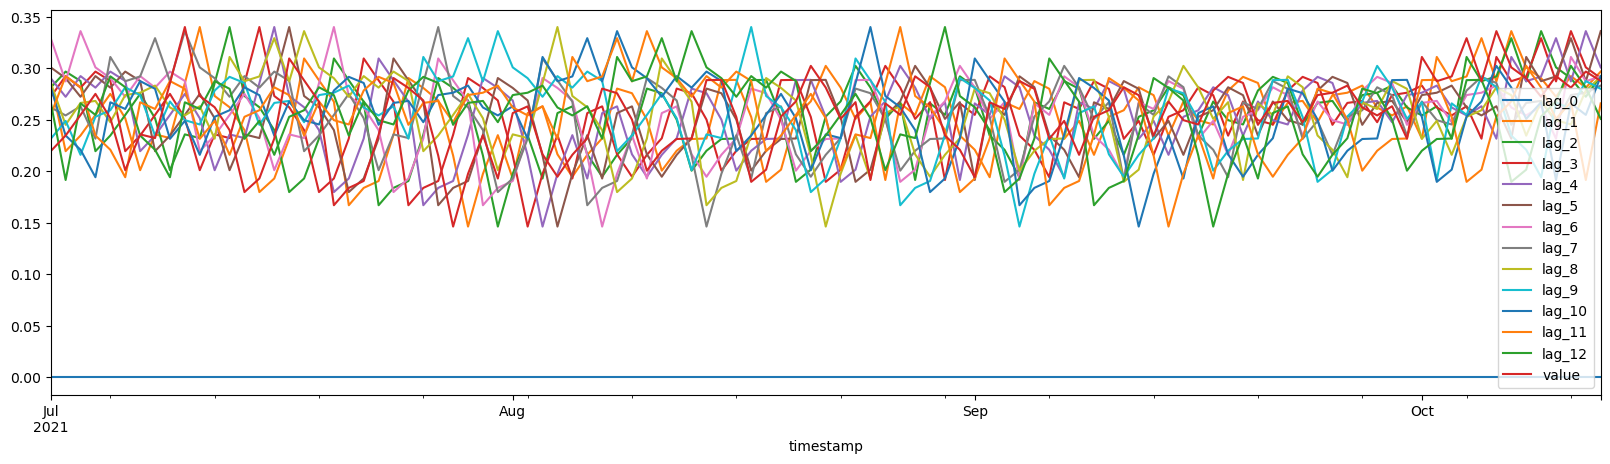

In [84]:
sample_dataset_lagged.plot(figsize=(20, 5))